# Formular la pregunta

### "Cuál es la probabilidad que un tweet que origina dentro de los coordinados geográficos (-78.31, 0.44, -70.71, 11.39) contiene al menos una ocurrencia de la palabra 'yo' con cualquier composición de acentos y letras minúsculas y mayúsculas."

![](http://mediossociales.es/wp-content/uploads/2012/01/twitter_futbol12.jpg)

# Recopilar datos

In [1]:
import os

import tweepy
from tweepy import Stream

from stream_listener import FiniteStreamListener

### Cargar credenciales

In [3]:
CONSUMER_KEY = os.getenv('TWITTER_CONSUMER_KEY')
CONSUMER_SECRET = os.getenv('TWITTER_CONSUMER_SECRET')
ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

In [4]:
COLOMBIA_GEO_LOCATION_BOUNDING_BOX = [-78.31, 0.44, -70.71, 11.39]
NUMBER_OF_TWEETS = 100

In [5]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

### Establecer una conexión al API de Twitter

In [6]:
finite_stream_listener = FiniteStreamListener(number_of_tweets=NUMBER_OF_TWEETS)
streaming_api = Stream(auth=auth, listener=finite_stream_listener)

### Sorber del firehouse

In [7]:
streaming_api.filter(locations=COLOMBIA_GEO_LOCATION_BOUNDING_BOX)

# Limpiar datos

In [8]:
from unidecode import unidecode

### Definir funciones de limpieza

In [12]:
def make_lowercase(tweet):
    return tweet.lower()


def remove_diacritics(tweet):
    return unidecode(tweet)


def remove_non_alpha_characters(tweet):
    return ''.join(character for character in tweet if character.isalpha() or character == ' ')

### Aplicar las funciones

In [13]:
cleaned_tweets = list(finite_stream_listener.tweets)

for cleaning_function in [make_lowercase, remove_diacritics, remove_non_alpha_characters]:
    cleaned_tweets = [cleaning_function(tweet) for tweet in cleaned_tweets]

# Dormir con tus datos

In [47]:
%matplotlib inline

from pprint import pprint
import pandas as pd

In [20]:
KEYWORD = 'yo'

### Primeros 10 tweets

In [ ]:
pprint(cleaned_tweets[:10])

### ¿Cuantas veces aparece la palabra clave?

In [ ]:
number_of_occurences = sum(KEYWORD in tweet for tweet in cleaned_tweets)
print('Nuestra palabra clave aparece: {} veces'.format(number_of_occurences))

### ¿Con cual frecuencia apareció?

In [31]:
print('Nuestra palabra clave apareció en: {}% de los tweets'.format(100 * number_of_occurences/NUMBER_OF_TWEETS))

Nuestra palabra clave apareció en: 5.0% de los tweets


### ¿Cómo son los tweets que la contienen?

In [49]:
pprint([tweet for tweet in cleaned_tweets if KEYWORD in tweet])

['ordonez a mi no me echan yo renuncio',
 'mi hermano y yo',
 'gspdesind es que la mudgre es eso mudcriacuervos con el zopilote mayor al '
 'frente httpstcojefttcda',
 'paoleiva mk yo tambien jajajaja',
 'joslu este tweet no lo escribo yo  te voy poner un poster del negro de '
 'whatssap en el carro en la   karinakarina y yo te queremos']


### ¿Cuál es la distancia promedia entre ocurrencias consecutivas?

In [50]:
indices_of_tweets_containing_keyword = [index for index, tweet in enumerate(cleaned_tweets) if KEYWORD in tweet]

In [51]:
indices_of_tweets_containing_keyword

[8, 28, 31, 32, 61]

In [52]:
distances_between_indices_of_tweets_containing_keyword = [
    second_index - first_index for first_index, second_index in \
        zip(indices_of_tweets_containing_keyword[:-1], indices_of_tweets_containing_keyword[1:])
]

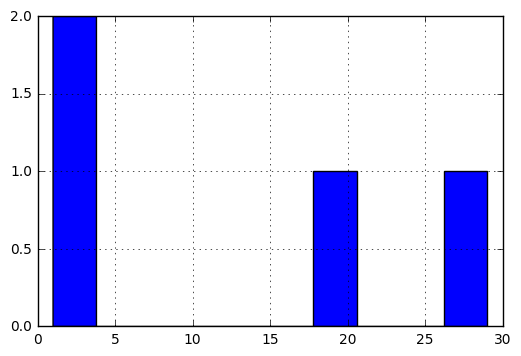

In [53]:
pd.Series(distances_between_indices_of_tweets_containing_keyword).hist()

# Construir un modelo

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta as beta_distribution

### Definir los parámetros de un Beta Distribution

In [10]:
alpha = 1 + number_of_occurences
beta = 1 + (NUMBER_OF_TWEETS - number_of_occurences)

x_values = np.linspace(0, 1, 1002)[1:-1]
pdf_y_values = beta_distribution(alpha, beta).pdf(x_values)
cdf_y_values = np.cumsum(pdf_y_values) / np.sum(pdf_y_values)

### Visualizar

![](http://i.imgur.com/mj059cS.png)

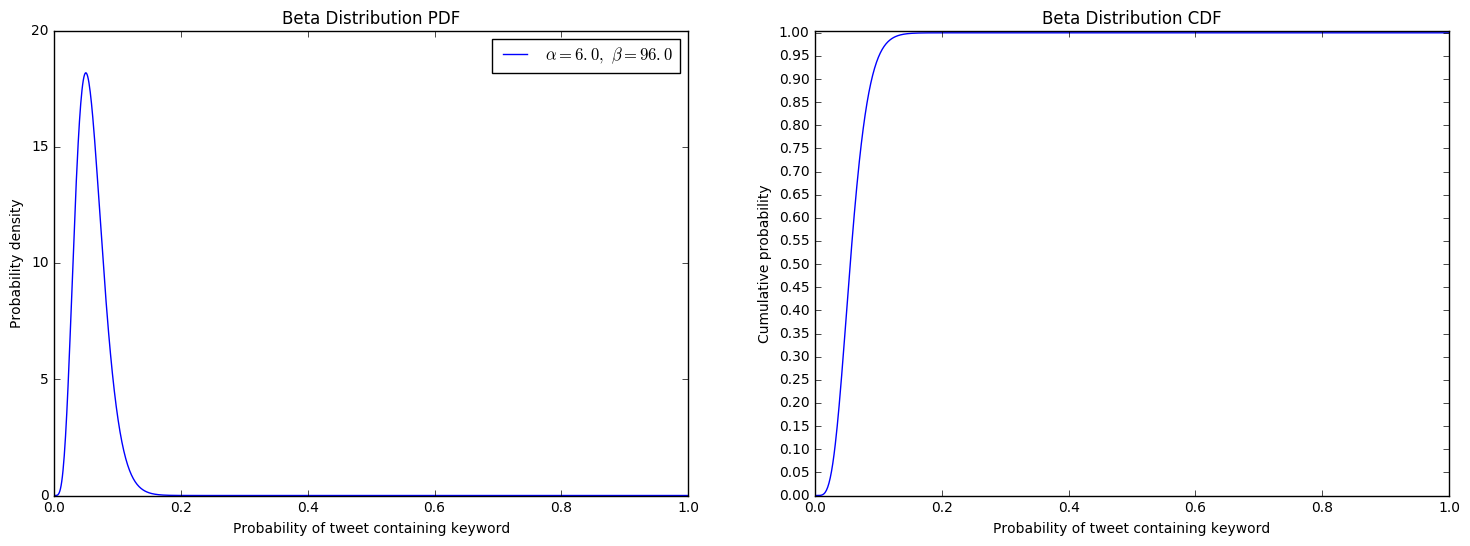

In [12]:
plt.figure(figsize=(18, 6))

# PDF
plt.subplot(121)

plt.plot(x_values, pdf_y_values, label=(r'$\alpha=%.1f,\ \beta=%.1f$' % (alpha, beta)))

plt.xlim(0, 1)
plt.xlabel('Probability of tweet containing keyword')
plt.ylabel('Probability density')
plt.title('Beta Distribution PDF')
plt.legend(loc=1)


# CDF
plt.subplot(122)

plt.plot(x_values, cdf_y_values)

plt.xlim(0, 1)
plt.ylim(0, 1.005)
plt.yticks(np.linspace(0, 1, 21))
plt.xlabel('Probability of tweet containing keyword')
plt.ylabel('Cumulative probability')
plt.title('Beta Distribution CDF')

plt.show()

# Comunicar resultados

### Con 90% de certeza, digamos que la verdadera probabilidad:

In [13]:
fifth_percentile = max(
    [x_value for x_value, y_value in zip(x_values, cdf_y_values) if y_value <= .05]
)

ninety_fifth_percentile = max(
    [x_value for x_value, y_value in zip(x_values, cdf_y_values) if y_value <= .95]
)

In [14]:
print('Con 90% de certeza digamos que la verdadera probabilidad se encuentra entre: {} y {}'.format(
    round(fifth_percentile, 4), round(ninety_fifth_percentile, 4)))

Con 90% de certeza digamos que la verdadera probabilidad se encuentra entre: 0.025 y 0.0999


### La probabilidad que la verdadera probabilidad (de que un tweet contiene nuesta palabra clave) sea más grande de .1:

In [16]:
def compute_total_probability_that_probability_less_than_p(p):
    return max(cumulative_prob for cumulative_prob, x_value in zip(cdf_y_values, x_values) if x_value < p)

In [17]:
print('La probabilidad que la verdadera probabilidad es > .1 es: {}'.format(
    1 - compute_total_probability_that_probability_less_than_p(.1))
)

La probabilidad que la verdadera probabilidad es > .1 es: 0.05283081449236815
